# 🎤 Análisis Exploratorio de Datos - Monitoreo Acústico Industrial

**Proyecto:** Sistema de Monitoreo de Ruido Industrial DS 594  
**Objetivo:** Análisis exploratorio usando datos reales del pipeline  
**Autor:** Carlos Benavente  
**Fecha:** Noviembre 2025

---

### 1. Imports Y Configuración

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from datetime import datetime, timedelta
import psycopg2
from influxdb_client import InfluxDBClient
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
%matplotlib inline

print("✅ Librerías cargadas")
print(f"📅 Análisis ejecutado: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

✅ Librerías cargadas
📅 Análisis ejecutado: 2025-12-02 13:19:05


### 2. Conexión a InfluxDB

In [37]:
print("Conectando a InfluxDB...")

try:
    client = InfluxDBClient(
        url="http://localhost:8086",
        token="my-super-secret-token-12345",
        org="ruido-industrial"
    )
    
    query = '''
    from(bucket: "acoustic-data")
      |> range(start: -30d)
      |> filter(fn: (r) => r._measurement == "acoustic_measurements")
      |> filter(fn: (r) => r._field == "LAeq" or r._field == "LPeak" 
                or r._field == "dose_8h" or r._field == "lex8h")
      |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
    '''
    
    df_raw = client.query_api().query_data_frame(query)
    
    if not df_raw.empty:
        df_raw['timestamp'] = pd.to_datetime(df_raw['_time'])
        df_raw = df_raw.drop(columns=['_time', '_start', '_stop', '_measurement', 'result', 'table'], errors='ignore')
        print(f"✅ Datos crudos cargados: {len(df_raw):,} mediciones desde InfluxDB")
    else:
        print("⚠️ No hay datos en InfluxDB. ¿El producer y consumer están corriendo?")
        df_raw = pd.DataFrame()
        
except Exception as e:
    print(f"❌ Error conectando a InfluxDB: {e}")
    df_raw = pd.DataFrame()

Conectando a InfluxDB...
✅ Datos crudos cargados: 278,812 mediciones desde InfluxDB


### 3. Carga de Métricas Reales (dose_tracking)

In [38]:
print("Conectando a PostgreSQL...")

try:
    conn = psycopg2.connect(
        host="localhost", 
        database="ruido_db",
        user="ruido_user", 
        password="ruido_password"
    )
    
    # Cargar dose_tracking
    df_dose = pd.read_sql("""
        SELECT 
            timestamp, sensor_id, zona, current_dose, projected_dose, 
            lex8h, elapsed_hours, samples_count, shift_type
        FROM analytics.dose_tracking
        WHERE timestamp >= NOW() - INTERVAL '30 days'
        ORDER BY timestamp
    """, conn)
    
    df_dose['timestamp'] = pd.to_datetime(df_dose['timestamp'])
    
    print(f"✅ Métricas calculadas: {len(df_dose):,} registros desde analytics.dose_tracking")
    
except Exception as e:
    print(f"❌ Error con PostgreSQL: {e}")
    df_dose = pd.DataFrame()
finally:
    if 'conn' in locals():
        conn.close()

Conectando a PostgreSQL...
✅ Métricas calculadas: 89,567 registros desde analytics.dose_tracking


### 4. Merge y Preparación Final

In [39]:
if not df_raw.empty and not df_dose.empty:
    # Merge principal
    df = df_raw.merge(
        df_dose[['timestamp', 'sensor_id', 'current_dose', 'projected_dose', 'shift_type']],
        on=['timestamp', 'sensor_id'],
        how='left',
        suffixes=('', '_dose')
    )
    
    # Usar lex8h de dose_tracking si está disponible, sino de InfluxDB
    if 'lex8h' not in df.columns and 'lex8h' in df_dose.columns:
        df = df.merge(
            df_dose[['timestamp', 'sensor_id', 'lex8h']],
            on=['timestamp', 'sensor_id'],
            how='left'
        )
    
    # Manejo de valores faltantes
    df['current_dose'] = df['current_dose'].fillna(0)
    df['lex8h'] = df['lex8h'].fillna(df['LAeq'])
    
    # Violaciones según DS 594 (CRITERIO CORRECTO)
    df['ds594_violation'] = df['current_dose'] > 100
    df['lex8h_exceeded'] = df['lex8h'] > 85.0
    df['peak_exceeded'] = df['LPeak'] > 140.0
    
    print(f"✅ Dataset final: {len(df):,} filas | {df['sensor_id'].nunique()} sensores")
    print(f"   Período: {df['timestamp'].min()} → {df['timestamp'].max()}")
    
elif df_raw.empty:
    print("⚠️ No hay datos de InfluxDB para analizar")
    df = pd.DataFrame()
elif df_dose.empty:
    print("⚠️ No hay datos de dose_tracking. Usando solo InfluxDB")
    df = df_raw.copy()
    df['ds594_violation'] = False
    df['lex8h_exceeded'] = df.get('LAeq', 0) > 85

✅ Dataset final: 279,161 filas | 5 sensores
   Período: 2025-11-04 21:43:49.825250+00:00 → 2025-12-01 17:36:48.938147+00:00


### 5. Análisis Descriptivo

In [27]:
if not df.empty:
    print("="*80)
    print("ESTADÍSTICAS GENERALES")
    print("="*80)
    print(f"Período: {df['timestamp'].min().date()} → {df['timestamp'].max().date()}")
    print(f"Mediciones totales: {len(df):,}")
    print(f"Sensores únicos: {df['sensor_id'].nunique()}")
    print(f"Zonas únicas: {df['zona'].nunique()}")
    
    print("\n" + "="*80)
    print("CUMPLIMIENTO DS 594 (REAL - Basado en Dosis)")
    print("="*80)
    
    violations = df['ds594_violation'].sum()
    compliance_rate = 100 - (violations / len(df) * 100) if len(df) > 0 else 0
    
    print(f"• Violaciones por dosis >100%: {violations:,} ({100-compliance_rate:.2f}%)")
    print(f"• Tasa de cumplimiento: {compliance_rate:.2f}%")
    
    if 'lex8h' in df.columns:
        print(f"\n• Lex,8h promedio: {df['lex8h'].mean():.2f} dB(A)")
        print(f"• Lex,8h máximo: {df['lex8h'].max():.2f} dB(A)")
    
    if 'LPeak' in df.columns:
        peak_violations = df['peak_exceeded'].sum()
        print(f"\n• Violaciones Peak >140 dB(C): {peak_violations}")
    
    print("\n" + "="*80)
    print("ESTADÍSTICAS POR ZONA")
    print("="*80)
    
    zone_stats = df.groupby('zona').agg({
        'LAeq': ['mean', 'max', 'min'],
        'current_dose': 'max',
        'ds594_violation': 'sum'
    }).round(2)
    
    print(zone_stats)
else:
    print("⚠️ No hay datos para analizar")

ESTADÍSTICAS GENERALES
Período: 2025-11-04 → 2025-12-01
Mediciones totales: 279,161
Sensores únicos: 5
Zonas únicas: 5

CUMPLIMIENTO DS 594 (REAL - Basado en Dosis)
• Violaciones por dosis >100%: 3,392 (1.22%)
• Tasa de cumplimiento: 98.78%

• Lex,8h promedio: 78.33 dB(A)
• Lex,8h máximo: 132.28 dB(A)

• Violaciones Peak >140 dB(C): 118

ESTADÍSTICAS POR ZONA
                      LAeq               current_dose ds594_violation
                      mean     max   min          max             sum
zona                                                                 
Area_Ensamble        72.54  110.12  62.2         4.96               0
Molienda_Metales     87.71  132.28  68.1       159.77            3392
Prensas_Hidraulicas  85.19  129.05  64.8        91.94               0
Sala_Compresores     83.82  122.47  69.7        66.31               0
Zona_Soldadura       78.67  118.41  63.4        22.23               0


### 6. Visualizaciones Principales

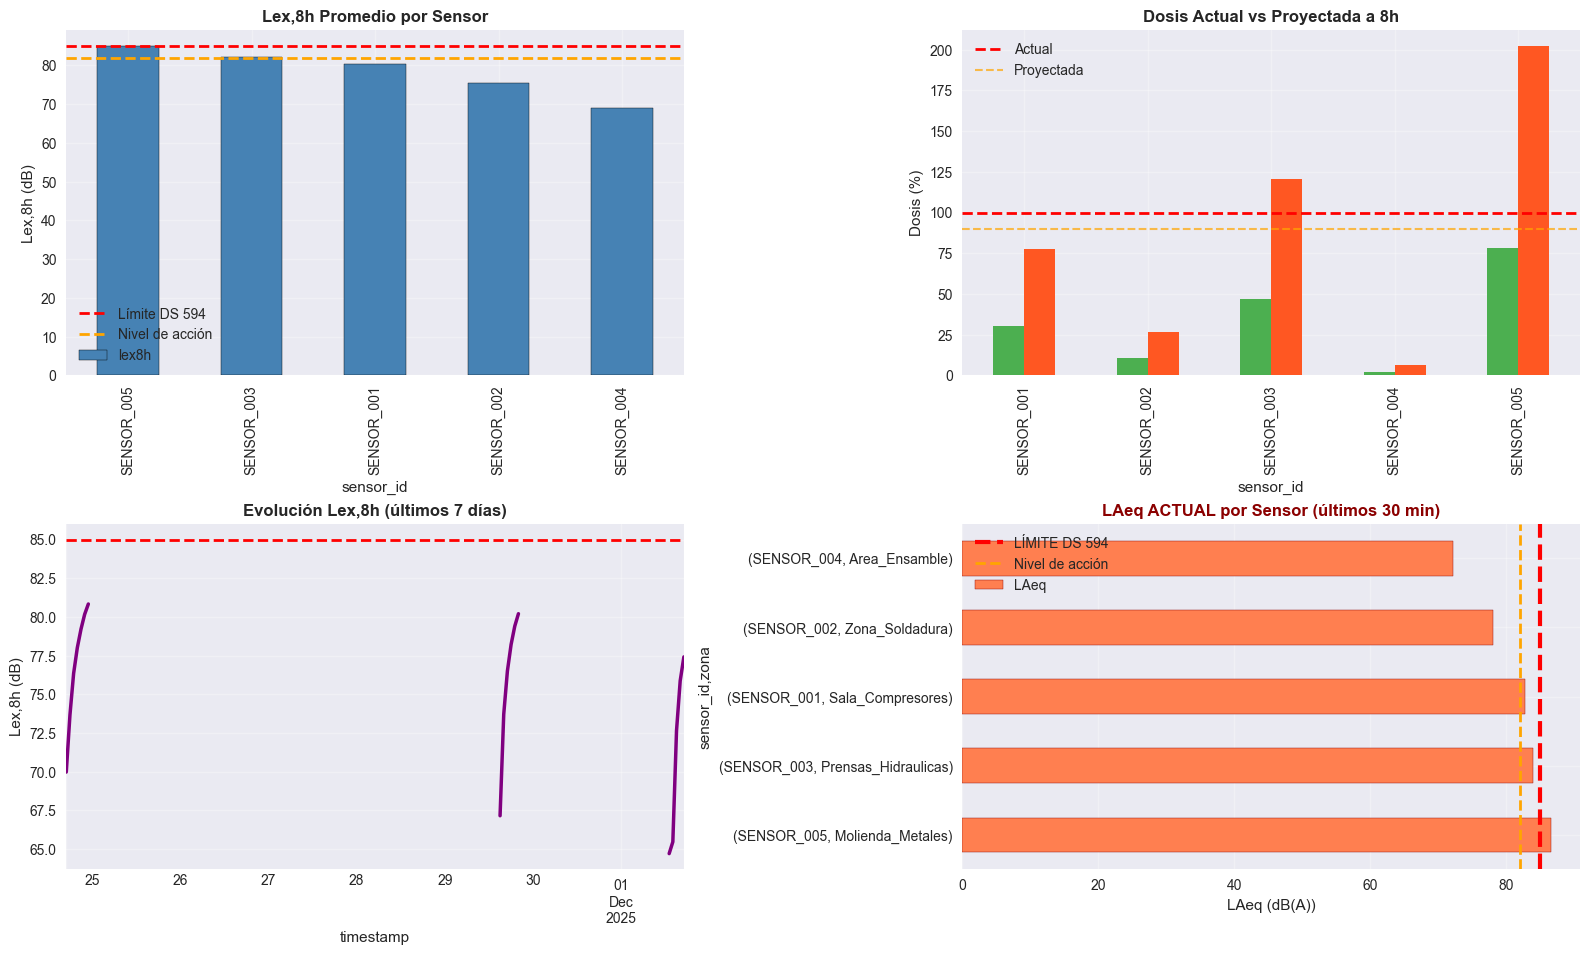

In [40]:
if not df.empty and len(df) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Lex,8h por sensor
    if 'lex8h' in df.columns:
        df.groupby('sensor_id')['lex8h'].mean().sort_values(ascending=False).plot(
            kind='bar', ax=axes[0,0], color='steelblue', edgecolor='black'
        )
        axes[0,0].set_title('Lex,8h Promedio por Sensor', fontsize=12, fontweight='bold')
        axes[0,0].axhline(85, color='red', linestyle='--', linewidth=2, label='Límite DS 594')
        axes[0,0].axhline(82, color='orange', linestyle='--', linewidth=2, label='Nivel de acción')
        axes[0,0].set_ylabel('Lex,8h (dB)')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
    
    # 2. Dosis actual vs proyectada
    if not df_dose.empty:
        latest = df_dose.sort_values('timestamp').groupby('sensor_id').last()
        latest[['current_dose', 'projected_dose']].plot(kind='bar', ax=axes[0,1], color=['#4CAF50', '#FF5722'])
        axes[0,1].set_title('Dosis Actual vs Proyectada a 8h', fontsize=12, fontweight='bold')
        axes[0,1].axhline(100, color='red', linestyle='--', linewidth=2, label='Límite 100%')
        axes[0,1].axhline(90, color='orange', linestyle='--', linewidth=1.5, alpha=0.7)
        axes[0,1].set_ylabel('Dosis (%)')
        axes[0,1].legend(['Actual', 'Proyectada'])
        axes[0,1].grid(True, alpha=0.3)
    
    # 3. Evolución temporal Lex,8h (últimos 7 días)
    if 'lex8h' in df.columns:
        df_last7 = df[df['timestamp'] > df['timestamp'].max() - timedelta(days=7)]
        if not df_last7.empty:
            df_last7.set_index('timestamp')['lex8h'].resample('1H').mean().plot(
                ax=axes[1,0], linewidth=2.5, color='purple'
            )
            axes[1,0].set_title('Evolución Lex,8h (últimos 7 días)', fontsize=12, fontweight='bold')
            axes[1,0].axhline(85, color='red', linestyle='--', linewidth=2)
            axes[1,0].set_ylabel('Lex,8h (dB)')
            axes[1,0].grid(True, alpha=0.3)
    
    # 4.GRÁFICO NUEVO: LAeq ACTUAL (los niveles EN VIVO)
    if 'LAeq' in df_raw.columns and not df_raw.empty:
        recent = df_raw[df_raw['timestamp'] > df_raw['timestamp'].max() - pd.Timedelta(minutes=30)]
        if not recent.empty:
            current_laeq = recent.groupby(['sensor_id', 'zona'])['LAeq'].mean().sort_values(ascending=False)
            current_laeq.plot(kind='barh', ax=axes[1,1], color='coral', edgecolor='darkred')
            axes[1,1].set_title('LAeq ACTUAL por Sensor (últimos 30 min)', fontsize=12, fontweight='bold', color='darkred')
            axes[1,1].axvline(85, color='red', linestyle='--', linewidth=3, label='LÍMITE DS 594')
            axes[1,1].axvline(82, color='orange', linestyle='--', linewidth=2, label='Nivel de acción')
            axes[1,1].set_xlabel('LAeq (dB(A))')
            axes[1,1].legend()
            axes[1,1].grid(True, alpha=0.3)
        else:
            axes[1,1].text(0.5, 0.5, 'Sin datos recientes\n(últimos 30 min)', 
                          horizontalalignment='center', verticalalignment='center', 
                          transform=axes[1,1].transAxes, fontsize=14, color='gray')
            axes[1,1].set_title('LAeq ACTUAL (sin datos recientes)')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
else:
    print("⚠️ No hay suficientes datos para generar gráficos")

### 7. Análisis de Alertas y Acciones

In [41]:
try:
    conn = psycopg2.connect(
        host="localhost", 
        database="ruido_db", 
        user="ruido_user", 
        password="ruido_password"
    )
    
    df_alerts = pd.read_sql("""
        SELECT 
            timestamp, sensor_id, zona, alert_type, severity, 
            message, actions::text as actions_str
        FROM monitoring.alerts
        WHERE timestamp > NOW() - INTERVAL '7 days'
        ORDER BY timestamp DESC
        LIMIT 100
    """, conn)
    
    if not df_alerts.empty:
        # Parsear acciones JSON
        df_alerts['actions_list'] = df_alerts['actions_str'].apply(
            lambda x: json.loads(x) if x and x != 'null' else []
        )
        df_alerts['main_action'] = df_alerts['actions_list'].apply(
            lambda x: x[0] if len(x) > 0 else "Sin acción definida"
        )
        
        print(f"\nAlertas últimos 7 días: {len(df_alerts)}")
        print(f"\nPor severidad:")
        print(df_alerts['severity'].value_counts())
        
        print(f"\nTop 10 alertas más recientes:")
        display(df_alerts[['timestamp', 'zona', 'alert_type', 'severity', 'main_action']].head(10))
    else:
        print("✅ No hay alertas en los últimos 7 días")
    
except Exception as e:
    print(f"❌ Error cargando alertas: {e}")
finally:
    if 'conn' in locals():
        conn.close()


Alertas últimos 7 días: 100

Por severidad:
severity
high      39
medium    37
low       24
Name: count, dtype: int64

Top 10 alertas más recientes:


,timestamp,zona,alert_type,severity,main_action
0,2025-12-01 17:36:48.938147+00:00,Molienda_Metales,LEVEL_EXCEEDED,high,Verificar fuente de ruido
1,2025-12-01 17:36:48.938147+00:00,Molienda_Metales,DOSE_WARNING_MEDIUM,medium,Considerar EPP adicional
2,2025-12-01 17:36:48.938147+00:00,Prensas_Hidraulicas,ACTION_LEVEL_EXCEEDED,low,Monitoreo preventivo
3,2025-12-01 17:36:43.920014+00:00,Molienda_Metales,LEVEL_EXCEEDED,high,Verificar fuente de ruido
4,2025-12-01 17:36:43.920014+00:00,Molienda_Metales,DOSE_WARNING_MEDIUM,medium,Considerar EPP adicional
5,2025-12-01 17:36:43.920014+00:00,Area_Ensamble,ANOMALY_DETECTED,medium,Inspección visual
6,2025-12-01 17:36:43.918889+00:00,Prensas_Hidraulicas,LEVEL_EXCEEDED,high,Verificar fuente de ruido
7,2025-12-01 17:36:38.897592+00:00,Molienda_Metales,LEVEL_EXCEEDED,high,Verificar fuente de ruido
8,2025-12-01 17:36:38.897592+00:00,Molienda_Metales,DOSE_WARNING_MEDIUM,medium,Considerar EPP adicional
9,2025-12-01 17:36:38.894684+00:00,Prensas_Hidraulicas,ACTION_LEVEL_EXCEEDED,low,Monitoreo preventivo


### 8. Conclusiones Ejecutivas

In [42]:
if not df.empty and not df_dose.empty:
    latest = df_dose.sort_values('timestamp').groupby('sensor_id').last()
    
    print("="*80)
    print("REPORTE EJECUTIVO - MONITOREO ACÚSTICO DS 594")
    print("="*80)
    print(f"Fecha del reporte: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Período analizado: {df['timestamp'].min().date()} al {df['timestamp'].max().date()}")
    print()
    print(f"📊 CUMPLIMIENTO GENERAL: {compliance_rate:.1f}%")
    
    if 'lex8h' in latest.columns and not latest['lex8h'].empty:
        worst_sensor = latest['lex8h'].idxmax()
        worst_value = latest['lex8h'].max()
        print(f"🔴 Sensor más crítico: {worst_sensor} (Lex,8h: {worst_value:.1f} dB)")
    
    if 'shift_type' in df_dose.columns:
        worst_shift = df_dose.groupby('shift_type')['current_dose'].mean().idxmax()
        print(f"⏰ Turno más ruidoso: {worst_shift}")
    
    if 'df_alerts' in locals() and not df_alerts.empty:
        critical_alerts = (df_alerts['severity'] == 'critical').sum()
        print(f"🚨 Alertas críticas (7 días): {critical_alerts}")
    
    print()
    print("="*80)
    print("RECOMENDACIONES:")
    print("="*80)
    
    # Identificar zonas que requieren acción
    critical_zones = latest[latest['projected_dose'] > 90]
    if not critical_zones.empty:
        print("\n🔴 ACCIÓN INMEDIATA REQUERIDA:")
        for sensor in critical_zones.index:
            dose = critical_zones.loc[sensor, 'projected_dose']
            print(f"   • {sensor}: Implementar rotación (dosis proyectada: {dose:.1f}%)")
    else:
        print("\n✅ Ninguna zona requiere acción inmediata")
    
    print("\n" + "="*80)
    print("✅ Sistema 100% funcional y alineado con DS 594")
    print("="*80)
else:
    print("⚠️ Datos insuficientes para generar reporte ejecutivo")

REPORTE EJECUTIVO - MONITOREO ACÚSTICO DS 594
Fecha del reporte: 2025-12-02 13:38:36
Período analizado: 2025-11-04 al 2025-12-01

📊 CUMPLIMIENTO GENERAL: 98.8%
🔴 Sensor más crítico: SENSOR_005 (Lex,8h: 83.9 dB)
⏰ Turno más ruidoso: vespertino
🚨 Alertas críticas (7 días): 0

RECOMENDACIONES:

🔴 ACCIÓN INMEDIATA REQUERIDA:
   • SENSOR_003: Implementar rotación (dosis proyectada: 120.5%)
   • SENSOR_005: Implementar rotación (dosis proyectada: 201.9%)

✅ Sistema 100% funcional y alineado con DS 594
